<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

In this competition, the challenge is to build a machine learning model that predicts if a text is written by an AI or by a student.

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Detect AI Generated Text dataset
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Generate the submission file


In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt


print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2024-03-07 09:40:43.703576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 09:40:43.703636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 09:40:43.870592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 09:40:44.183385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 09:41:00.960020: W tensorflow/compiler/tf2

Using TensorFlow backend
TensorFlow version: 2.15.0
Keras version: 0.1.7
KerasNLP version: 0.8.2


# Load the Detect AI Generated Text
Let's have a look at all the data files

In [2]:
DATA_DIR = '/mnt/beegfs/xchen87/ai-gen/data/llm-detect-ai-generated-text/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/beegfs/xchen87/ai-gen/data/llm-detect-ai-generated-text/train_essays.csv
/mnt/beegfs/xchen87/ai-gen/data/llm-detect-ai-generated-text/train_prompts.csv
/mnt/beegfs/xchen87/ai-gen/data/llm-detect-ai-generated-text/sample_submission.csv
/mnt/beegfs/xchen87/ai-gen/data/llm-detect-ai-generated-text/test_essays.csv


# Explore the dataset

Let's look at the distribution of labels in the training set.

In [3]:
df_train_prompts = pd.read_csv(DATA_DIR + "train_prompts.csv")
print(df_train_prompts.info())
df_train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


**Only two prompts are used in this dataset.**

Let's look at the distribution of text/generated in the training set.

In [4]:
df_train_essays = pd.read_csv(DATA_DIR + "train_essays.csv")
print(df_train_essays.info())
df_train_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


Text(0.5, 1.0, 'Distribution of prompt ID')

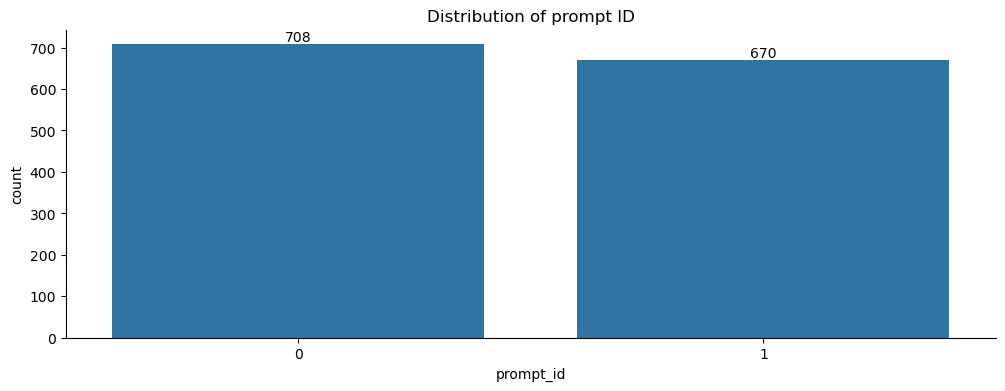

In [5]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays,
                   x="prompt_id")

abs_values = df_train_essays['prompt_id'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")

Text(0.5, 1.0, 'Distribution of Generated Text')

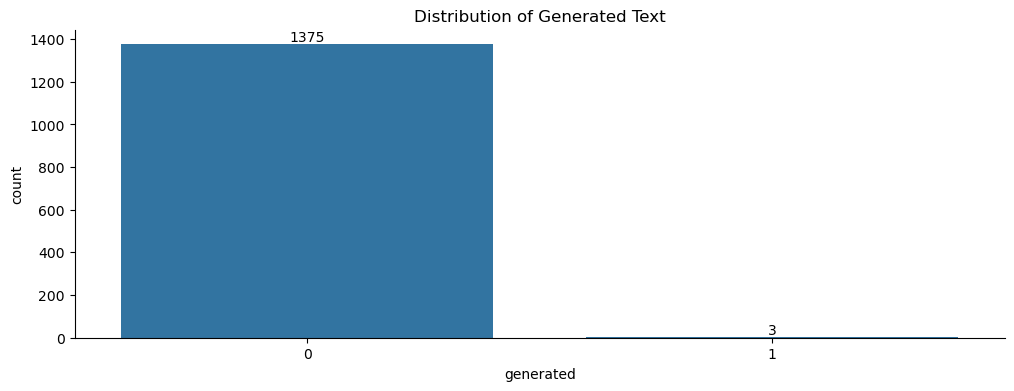

In [6]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays,
                   x="generated")

abs_values = df_train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

**1375 essays are written by human and only 3 by AI.**

**The distribution between the two prompts is pretty equal.**

In [7]:
df_test_essays = pd.read_csv(DATA_DIR + "test_essays.csv")
print(df_test_essays.info())
df_test_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None


,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [8]:
df_test_essays["text"].apply(lambda x : len(x))

0    12
1    12
2    12
Name: text, dtype: int64

**The test dataset contains only 3 essays. The length of each essay is very small (12 characters).**

# Add new data to the training dataset

As the dataset does not contain any generated data. We will use the dataset created by [DAREK KŁECZEK](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/455517)

In [9]:
df_train_essays_ext = pd.read_csv('/mnt/beegfs/xchen87/ai-gen/data/daigt-proper-train-dataset/train_drcat_04.csv')

df_train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)

df_train_essays_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44206 entries, 0 to 44205
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   44206 non-null  object
 1   text       44206 non-null  object
 2   generated  44206 non-null  int64 
 3   source     44206 non-null  object
 4   prompt     12911 non-null  object
 5   fold       44206 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [10]:
df_train_essays_ext.head()

,essay_id,text,generated,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0


Text(0.5, 1.0, 'Distribution of Generated Text')

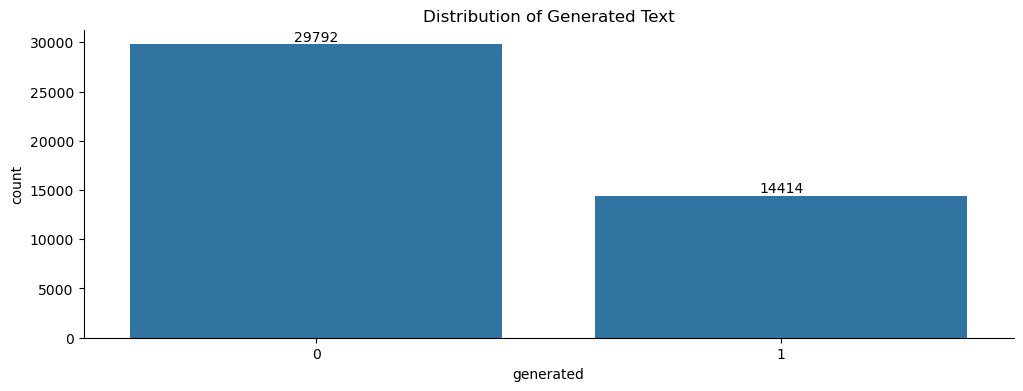

In [11]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_ext,
                   x="generated")

abs_values = df_train_essays_ext['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [12]:
df_train_essays


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [13]:
df_train_essays_final = pd.concat([df_train_essays_ext[["text", "generated"]], df_train_essays[["text", "generated"]]])

df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45584 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       45584 non-null  object
 1   generated  45584 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


# Prepare data

Let's count the number of words in each essay

In [14]:
df_train_essays["text_length"] = df_train_essays["text"].apply(lambda x : len(x.split()))

Text(0.5, 0.98, 'Distribution of the length per essay - Train dataset')

<Figure size 4000x5000 with 0 Axes>

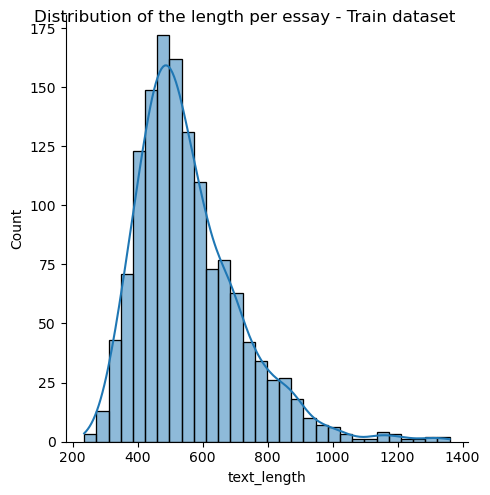

In [15]:
fig = plt.figure(figsize=(40,50))
plot = sns.displot(data=df_train_essays,
                 x="text_length", bins=30, kde=True)
plot.fig.suptitle("Distribution of the length per essay - Train dataset")


In [16]:
df_train_essays["text_length"].mean() + df_train_essays["text_length"].std()

716.0440978092684

# Create the model

In [17]:
# We choose 512 because it's the limit of DistilBert
SEQ_LENGTH = 512

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=SEQ_LENGTH,
)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=2,
    activation=None,
    preprocessor=preprocessor,
)

# Re-compile (e.g., with a new learning rate)
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy()
   ]
)
    

# Access backbone programmatically (e.g., to change `trainable`).
classifier.backbone.trainable = False


classifier.summary()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 580/580 [00:00<00:00, 8.58kB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226k/226k [00:00<00:00, 1.23MB/s]
2024-03-07 09:42:43.720273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 09:42:43.819741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-

AttributeError: 'Variable' object has no attribute '_distribute_strategy'

In [ ]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_essays_final["text"],
                                                    df_train_essays_final["generated"],
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
# Fit
classifier.fit(x=X_train, 
               y=y_train,
               validation_data=(X_test, y_test),
               epochs=1,
               batch_size=64
              )

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Generated","Generated"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


In [ ]:
y_pred_test = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred_test,  "Test")